In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/SIC_share'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


/content/drive/MyDrive/SIC_share/price_train.csv
/content/drive/MyDrive/SIC_share/sample_submission.csv
/content/drive/MyDrive/SIC_share/get_data.ipynb
/content/drive/MyDrive/SIC_share/lgbm.ipynb
/content/drive/MyDrive/SIC_share/price_test.csv
/content/drive/MyDrive/SIC_share/price_new.csv
/content/drive/MyDrive/SIC_share/sub_2.csv
/content/drive/MyDrive/SIC_share/RNN.ipynb
/content/drive/MyDrive/SIC_share/sub.csv
/content/drive/MyDrive/SIC_share/lgbm_new.ipynb
/content/drive/MyDrive/SIC_share/vnquant-master/.gitignore
/content/drive/MyDrive/SIC_share/vnquant-master/setup.py
/content/drive/MyDrive/SIC_share/vnquant-master/test.py
/content/drive/MyDrive/SIC_share/vnquant-master/requirements.txt
/content/drive/MyDrive/SIC_share/vnquant-master/README.md
/content/drive/MyDrive/SIC_share/vnquant-master/vnquant/__version__.py
/content/drive/MyDrive/SIC_share/vnquant-master/vnquant/__init__.py
/content/drive/MyDrive/SIC_share/vnquant-master/vnquant/imgs/stock_4.png
/content/drive/MyDrive/SIC_

In [2]:
train_price = pd.read_csv('/content/drive/MyDrive/SIC_share/price_new.csv')
test_price = pd.read_csv('/content/drive/MyDrive/SIC_share/price_test.csv')


In [3]:
train_price['datetime'] = pd.to_datetime(train_price['date'])
train_price.sort_values(['symbol','datetime'],inplace=True)

In [4]:
test_price.drop(columns=['close'],inplace=True)

In [5]:
symbols = test_price['symbol'].unique()


In [6]:
df_horizontal_symbols = pd.pivot_table(train_price,
               index = 'date',
               columns = 'symbol',
               values = 'close',
               aggfunc = {
                   'close': lambda x: x
               }
              )

In [7]:
df_horizontal_symbols.index = pd.to_datetime(df_horizontal_symbols.index)

In [8]:
idx = pd.date_range(min(df_horizontal_symbols.index), max(df_horizontal_symbols.index))

In [9]:
df_horizontal_symbols = df_horizontal_symbols.reindex(idx,method='ffill')

In [10]:
check_null = {}
for symbol in symbols:
    check_null[symbol] = df_horizontal_symbols[symbol].isnull()

In [11]:
df_horizontal_symbols.fillna(method='ffill',inplace=True)

<ipython-input-11-7d9797cf795f>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_horizontal_symbols.fillna(method='ffill',inplace=True)


In [ ]:
def make_feature(feat_14_day):
    mean_14_day = np.mean(feat_14_day)
    std_14_day = np.std(feat_14_day)
    max_14_day = np.max(feat_14_day)
    min_14_day = np.min(feat_14_day)

    feat_7_day = feat_14_day[7:]
    mean_7_day = np.mean(feat_7_day)
    std_7_day = np.std(feat_7_day)
    max_7_day = np.max(feat_7_day)
    min_7_day = np.min(feat_7_day)

    log_return = list(np.diff(np.log(feat_14_day)))

    return feat_14_day + [std_14_day, max_14_day, min_14_day, mean_7_day, std_7_day, max_7_day, min_7_day] + log_return

column_names = [f'day-{i}' for i in range(14,0,-1)] + ['std_14_day','max_14_day', 'min_14_day','mean_7_day','std_7_day', 'max_7_day', 'min_7_day'] + [f'log_return_day-{i}' for i in range(13,0,-1)]

In [ ]:
X_train = []
X_valid = []
y_train = []
y_valid = []
X_train_symbol = []
X_valid_symbol = []
for symbol in symbols:
    print(symbol)
    check = check_null[symbol]
    values = df_horizontal_symbols[symbol].values
    x = []
    y = []
    for i in range(0,df_horizontal_symbols.shape[0]-14):
        if not check[i+14]:
            feat_14_day = list(values[i:i+14])
            feats = make_feature(feat_14_day)
            x.append(feats)
            y.append(values[i+14])
        else:
            print('meow')
    a = int(len(x)*0.75)
    X_train.extend(x[:a])
    X_valid.extend(x[a:])
    y_train.extend(y[:a])
    y_valid.extend(y[a:])
    X_train_symbol.extend([symbol]*a)
    X_valid_symbol.extend([symbol]*(len(x)-a))

STB
SSI


<ipython-input-56-8691dc2f9990>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if not check[i+14]:


TCB
VPB
HPG
MBB
POW
CTG
TCH
HDB
VHM
VRE
VIC
SBT
NVL
PDR
BID
VNM
PLX
TPB
MWG
FPT
PNJ
MSN
KDH
GAS
BVH
VJC
VCB
REE


In [ ]:
X_train = np.array(X_train)
X_valid = np.array(X_valid)
y_train = np.array(y_train)
y_valid = np.array(y_valid)

X_train = pd.DataFrame(X_train)
X_train.columns =column_names
X_train['symbol'] = X_train_symbol
X_valid = pd.DataFrame(X_valid)
X_valid.columns = column_names
X_valid['symbol'] = X_valid_symbol

X_train['symbol'] = X_train['symbol'].astype('category')
X_valid['symbol'] = X_valid['symbol'].astype('category')

In [ ]:
model = LGBMRegressor(random_state=42, n_estimators=500)

In [ ]:
model.fit(
          X_train, y_train,
          eval_set=[(X_train, y_train),(X_valid, y_valid)],
          eval_metric=['MAPE'],
          categorical_feature=['symbol'],
          )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8700
[LightGBM] [Info] Number of data points in the train set: 13080, number of used features: 35
[LightGBM] [Info] Start training from score 42.977674


LGBMRegressor(n_estimators=500, random_state=42)

In [ ]:
y_pred = model.predict(X_valid)

In [ ]:
X_valid['y_true'] = y_valid
X_valid['y_pred'] = y_pred

In [ ]:
def mape(y_true,y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    score = np.mean(abs(y_true - y_pred)/y_true)*100
    return score

In [ ]:
def calculate_mape(g):
    return mape(g['y_true'],g['y_pred'])

X_valid.groupby('symbol')[['y_true','y_pred']].apply(lambda x: calculate_mape(x)).sort_values()

<ipython-input-24-08103238499f>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X_valid.groupby('symbol')[['y_true','y_pred']].apply(lambda x: calculate_mape(x)).sort_values()


,0
symbol,
GAS,0.698797
VCB,0.698933
VIC,0.730293
VHM,0.746093
VNM,0.806208
HPG,0.911303
VPB,0.951650
PNJ,0.954628
BVH,0.980191


In [ ]:
def evaluate_regression(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    print(f'R² Score: {r2:.4f}')
evaluate_regression(y_valid, y_pred)

Mean Absolute Error (MAE): 0.9096
Root Mean Squared Error (RMSE): 3.0403
R² Score: 0.9896


<Axes: xlabel='importance', ylabel='feature'>

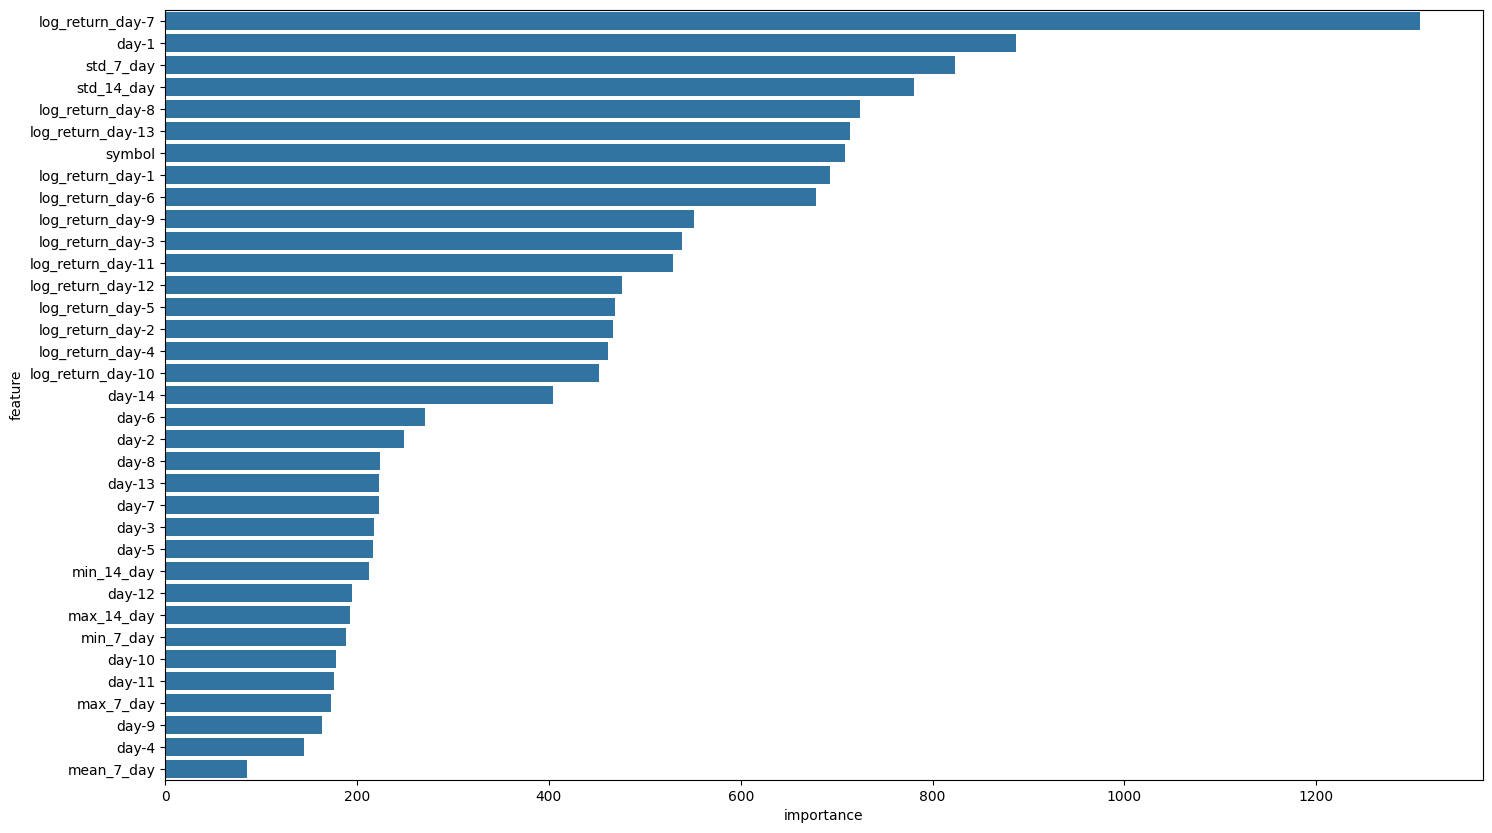

In [ ]:
df_feature_importance = (
    pd.DataFrame({
        'feature': model.feature_name_,
        'importance': model.feature_importances_,
    })
    .sort_values('importance', ascending=False)
)
plt.figure(figsize=(17,10))
sns.barplot(x='importance', y='feature', data=df_feature_importance)

In [ ]:
future_dates = pd.date_range('2024-08-20', '2024-09-19')

In [ ]:
for date in future_dates:
    print(date)
    X_test = []
    X_test_symbol = []
    for symbol in symbols:
        feat_14_day = df_horizontal_symbols.tail(14)[symbol].to_list()
        feats = make_feature(feat_14_day)
        X_test.append(feats)
        X_test_symbol.append(symbol)
    X_test = pd.DataFrame(X_test)
    X_test.columns = column_names
    X_test['symbol'] = X_test_symbol
    X_test['symbol'] = X_test['symbol'].astype('category')
    nextday = pd.DataFrame({'symbol': symbols,
                        'Predicted': model.predict(X_test),
                        'date': [date]*len(symbols)})
    nextday_horizontal_symbols = pd.pivot_table(nextday,
               index = 'date',
               columns = 'symbol',
               values = 'Predicted',
               aggfunc = {
                   'Predicted': lambda x: x
               }
              )
    df_horizontal_symbols = pd.concat([df_horizontal_symbols, nextday_horizontal_symbols])

2024-08-20 00:00:00
2024-08-21 00:00:00
2024-08-22 00:00:00
2024-08-23 00:00:00
2024-08-24 00:00:00
2024-08-25 00:00:00
2024-08-26 00:00:00
2024-08-27 00:00:00
2024-08-28 00:00:00
2024-08-29 00:00:00
2024-08-30 00:00:00
2024-08-31 00:00:00
2024-09-01 00:00:00
2024-09-02 00:00:00
2024-09-03 00:00:00
2024-09-04 00:00:00
2024-09-05 00:00:00
2024-09-06 00:00:00
2024-09-07 00:00:00
2024-09-08 00:00:00
2024-09-09 00:00:00
2024-09-10 00:00:00
2024-09-11 00:00:00
2024-09-12 00:00:00
2024-09-13 00:00:00
2024-09-14 00:00:00
2024-09-15 00:00:00
2024-09-16 00:00:00
2024-09-17 00:00:00
2024-09-18 00:00:00
2024-09-19 00:00:00


In [ ]:
df_horizontal_symbols.reset_index(inplace=True)
df_horizontal_symbols.rename(columns={'index':'date'},inplace=True)

In [ ]:
predictions = df_horizontal_symbols.tail(30).melt(id_vars=['date'],value_name='Predicted')
predictions['Id'] = predictions['date'].astype(str) + ':' + predictions['symbol']

In [ ]:
test_price['Id'] = test_price['date'].astype(str) + ':' + test_price['symbol']
test_price = test_price.merge(predictions[['Id','Predicted']],how='left',on='Id')

In [ ]:
mean_all = ["TCH","SSI","MWG","HDB","POW"]
others = set(symbols)  - set(mean_all)
mean_full_predict = train_price[train_price['symbol'].isin(mean_all)].groupby(['symbol'])['close'].apply(lambda x: np.mean(list(x))).reset_index()
mean_full_predict.columns = ['symbol', 'topping']
mean_last14_predict = train_price[train_price['symbol'].isin(others)].groupby(['symbol'])['close'].apply(lambda x: np.mean(list(x)[-14:])).reset_index()
mean_last14_predict.columns = ['symbol', 'topping']

In [ ]:
topping = pd.concat([mean_full_predict, mean_last14_predict],axis=0).fillna(0)

In [ ]:
test_price = test_price.merge(topping,how='left',on='symbol')

In [ ]:
test_price['Predicted'] = (test_price['Predicted'] + test_price['topping']) / 2

In [ ]:
test_price[['Id','Predicted']].to_csv('/content/drive/MyDrive/SIC_share/sub.csv',index=False)